<a href="https://colab.research.google.com/github/harshilj0310/Data-Science-Notebooks/blob/main/Lemmetizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud gensim vaderSentiment summa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=1a89daa81ac4d7a339e606e1878b886b44496499468148f061cfb658739aa21d
  Stored in directory: /root/.cache/pip/wheels/70/26/84/58df5a55ebde6fd802666b6ac0b86909ecd018a2702b89d13c
Successfully built summa


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from summa.summarizer import summarize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow_datasets as tfds

In [ ]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
print("--- NLTK data downloaded ---")

--- NLTK data downloaded ---


In [ ]:
try:
    # Load the 'imdb_reviews' dataset (train split)
    # This will download the data to the Colab environment
    ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

    # Convert the dataset to a Pandas DataFrame
    print("Converting dataset to Pandas DataFrame...")
    df = tfds.as_dataframe(ds)

    # The 'label' column is 0 (neg) or 1 (pos). Let's create a text column
    df['label_text'] = df['label'].apply(lambda x: 'positive' if x == 1 else 'negative')

    # 'text' column is bytes, so we need to decode it
    df['text'] = df['text'].str.decode('utf-8')

    # For demonstration, we'll work with a smaller sample to speed up processing
    df_sample = df.sample(n=2500, random_state=42)

    print(f"Successfully loaded and sampled {len(df_sample)} reviews.")
    print("Dataset head:")
    # Show the new 'text' and 'label_text' columns
    print(df_sample[['text', 'label_text']].head())

except Exception as e:
    print(f"Error loading dataset with tfds: {e}")
    # Create a dummy dataframe to allow the rest of the script to run for demo purposes
    df_sample = pd.DataFrame({
        'text': [ # Renamed 'review' to 'text' to match tfds
            "This movie was fantastic! The acting was superb.",
            "I did not like this movie. It was boring and slow.",
            "An amazing film with a great plot and wonderful characters.",
            "Terrible. Just terrible. I wasted my time and money.",
            "A decent movie, not the best but not the worst either."
        ],
        'label_text': ['positive', 'negative', 'positive', 'negative', 'neutral'] # Renamed 'sentiment'
    })
    print("Loaded dummy data to proceed with script.")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.SLMG0J_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.SLMG0J_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.SLMG0J_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Converting dataset to Pandas DataFrame...
Successfully loaded and sampled 2500 reviews.
Dataset head:
                                                    text label_text
6868   I watched "Elephant Walk" for the first time i...   positive
24016  I would put this at the top of my list of film...   negative
9668   Police, investigations, murder, suspicion: we ...   positive
13640  I read Schneebaum's book (same title as this f...   positive
14018  Well, you'd better if you plan on sitting thro...   negative


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
    """Cleans and preprocesses a single text string."""
    # 1. Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # 2. Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Tokenize
    tokens = text.split()

    # 5. Remove stop words and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    # Join tokens back into a string
    return " ".join(cleaned_tokens)


In [ ]:
df_sample['cleaned_review'] = df_sample['text'].apply(clean_text)

print("--- Text preprocessing complete ---")
print("Cleaned data head:")
print(df_sample[['text', 'cleaned_review']].head())

--- Text preprocessing complete ---
Cleaned data head:
                                                    text  \
6868   I watched "Elephant Walk" for the first time i...   
24016  I would put this at the top of my list of film...   
9668   Police, investigations, murder, suspicion: we ...   
13640  I read Schneebaum's book (same title as this f...   
14018  Well, you'd better if you plan on sitting thro...   

                                          cleaned_review  
6868   watched elephant walk first time year struck s...  
24016  would put top list film category unwatchable t...  
9668   police investigation murder suspicion acquaint...  
13640  read schneebaums book title film first publish...  
14018  well youd better plan sitting amateurish bland...  


In [ ]:
sentiment_counts = df_sample['label_text'].value_counts()
print("Pre-labeled Sentiment Distribution:")
print(sentiment_counts)

# 2. On-the-fly detection with VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Gets VADER sentiment score and returns a label."""
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER to the original 'text' column (formerly 'review')
df_sample['vader_sentiment'] = df_sample['text'].apply(get_vader_sentiment)
vader_counts = df_sample['vader_sentiment'].value_counts()
print("\nVADER-detected Sentiment Distribution:")
print(vader_counts)

Pre-labeled Sentiment Distribution:
label_text
negative    1261
positive    1239
Name: count, dtype: int64

VADER-detected Sentiment Distribution:
vader_sentiment
positive    1664
negative     821
neutral       15
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

/tmp/ipython-input-1568162754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


Text(0.5, 0, 'Sentiment')

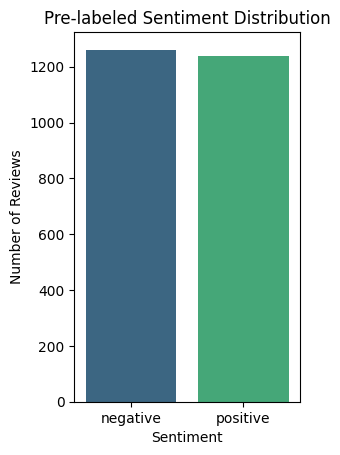

In [ ]:
# Plot 1: Pre-labeled Sentiment
plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Pre-labeled Sentiment Distribution')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment')

/tmp/ipython-input-711415027.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vader_counts.index, y=vader_counts.values, palette="plasma")


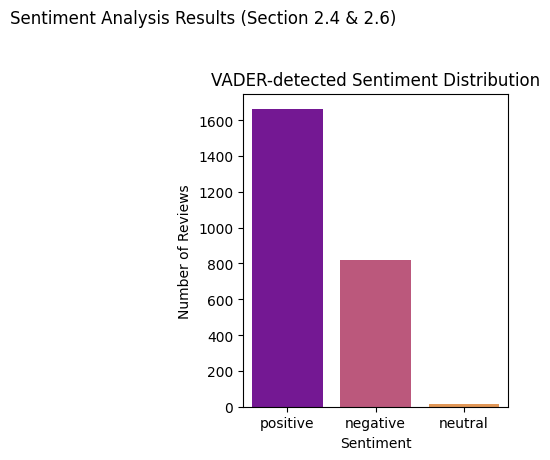

In [ ]:
# Plot 2: VADER-detected Sentiment
plt.subplot(1, 2, 2)
sns.barplot(x=vader_counts.index, y=vader_counts.values, palette="plasma")
plt.title('VADER-detected Sentiment Distribution')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment')

plt.suptitle('Sentiment Analysis Results (Section 2.4 & 2.6)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
vectorizer = CountVectorizer(max_df=0.8, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df_sample['cleaned_review'])

print(f"Document-Term Matrix shape: {doc_term_matrix.shape}")


Document-Term Matrix shape: (2500, 6111)


In [ ]:
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(doc_term_matrix)

print(f"\n--- Top 10 Words for each of the {num_topics} Topics ---")


--- Top 10 Words for each of the 5 Topics ---


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    """Helper function to display topics from LDA model."""
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [ ]:
feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, 10)

Topic #1: episode film character like time make life season story series
Topic #2: movie film like time people man scene character girl good
Topic #3: film movie like character good make story time way scene
Topic #4: film story time life love year like man great war
Topic #5: movie film like good really time bad character make story


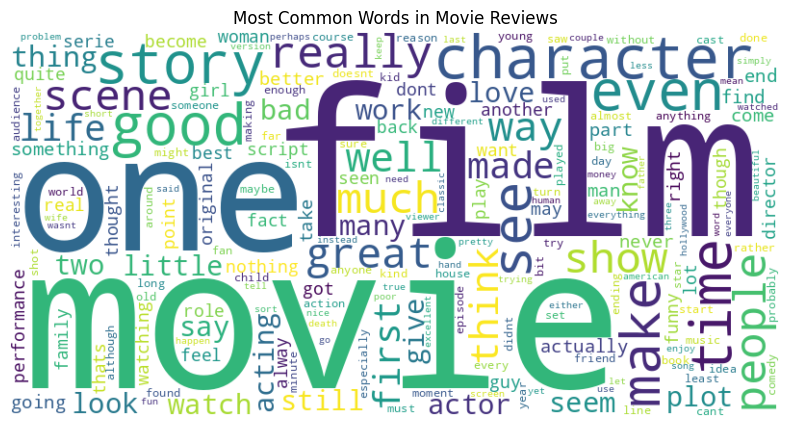

In [ ]:
all_text = " ".join(df_sample['cleaned_review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Movie Reviews')
plt.show()


In [ ]:
sample_review_text = df_sample['text'].iloc[0] # Use 'text' column

print(f"\nOriginal Review (length: {len(sample_review_text)} chars):")
print(sample_review_text)


Original Review (length: 1295 chars):
I watched "Elephant Walk" for the first time in about 30 years and was struck by how similar the story line is to the greatly superior "Rebecca." As others have said, you have the sweet young thing swept off her feet by the alternately charming and brooding lord of the manor, only to find her marriage threatened by the inescapable memory of a larger-than-life yet deeply flawed relative. You have the stern and disapproving servant, a crisis that will either bind the couple together or tear them irreparably apart, climaxed by the fiery destruction of the lavish homestead.<br /><br />Meanwhile, "Elephant Walk" also owes some of its creepy jungle atmosphere to "The Letter," the Bette Davis love triangle set on a Singapore rubber plantation rather than a Sri Lankan tea plantation.<br /><br />Maltin gives "Elephant Walk" just two stars, and IMDb readers aren't much kinder, but I enjoyed it despite its predictability. Elizabeth Taylor never looked loveli

In [ ]:
try:
    # Generate an extractive summary
    # words=50 means we want a summary of approx 50 words
    # Note: 'summa' uses 'words' parameter, not 'word_count'
    summary = summarize(sample_review_text, words=50)

    print(f"\nExtractive Summary (length: {len(summary)} chars):")
    print(summary)

except ValueError as e:
    print(f"\nCould not generate summary for this review (it might be too short): {e}")


print("\n\n--- NarrativeNexus Core Implementation Complete ---")


Extractive Summary (length: 534 chars):
You have the stern and disapproving servant, a crisis that will either bind the couple together or tear them irreparably apart, climaxed by the fiery destruction of the lavish homestead.<br /><br />Meanwhile, "Elephant Walk" also owes some of its creepy jungle atmosphere to "The Letter," the Bette Davis love triangle set on a Singapore rubber plantation rather than a Sri Lankan tea plantation.<br /><br />Maltin gives "Elephant Walk" just two stars, and IMDb readers aren't much kinder, but I enjoyed it despite its predictability.


--- NarrativeNexus Core Implementation Complete ---
